In [1]:
import numpy as np
import torch
from torch.utils.dlpack import to_dlpack
import cupy as cu
from cupyx import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
W = 50
H = 50
N = W * H
arr = torch.rand(H, W, device=device, dtype=torch.float32)
arr[25:50, 25:50] = 1
arr

tensor([[0.6996, 0.3515, 0.2224,  ..., 0.7357, 0.8228, 0.1044],
        [0.0155, 0.7229, 0.7512,  ..., 0.2460, 0.0996, 0.1493],
        [0.5602, 0.5500, 0.8593,  ..., 0.5051, 0.3407, 0.4367],
        ...,
        [0.9857, 0.5634, 0.4050,  ..., 1.0000, 1.0000, 1.0000],
        [0.0269, 0.6347, 0.3545,  ..., 1.0000, 1.0000, 1.0000],
        [0.3567, 0.1668, 0.5932,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0')

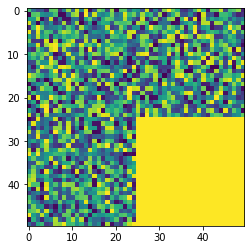

In [5]:
plt.imshow(arr.cpu().numpy())

In [6]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float32)

In [7]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:0'),
 torch.Size([4, 3, 3]))

In [8]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.6841, -0.3714, -0.5288,  ...,  0.4897,  0.7232, -0.0449],
          [-0.5447,  0.1729, -0.1081,  ..., -0.2591, -0.2411, -0.2874],
          ...,
          [-0.2650,  0.2023,  0.4703,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9588, -0.0713,  0.0505,  ...,  0.0000,  0.0000,  0.0000],
          [-0.3298,  0.4679, -0.2387,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.3482, -0.1290,  0.0502,  ...,  0.0871, -0.7184,  0.0000],
          [ 0.7074,  0.0283, -0.2394,  ..., -0.1464,  0.0497,  0.0000],
          [-0.0102,  0.3093, -0.8338,  ..., -0.1644,  0.0961,  0.0000],
          ...,
          [-0.4223, -0.1584,  0.4972,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.6077, -0.2802, -0.2563,  ...,  0.0000,  0.0000,  0.0000],
          [-0.1899,  0.4264,  0.0846,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.6841,  0.3714,  0.5288,  ..., -0.4897, -0.7232,  0.0449],
          [ 0.5447, -0.1729,

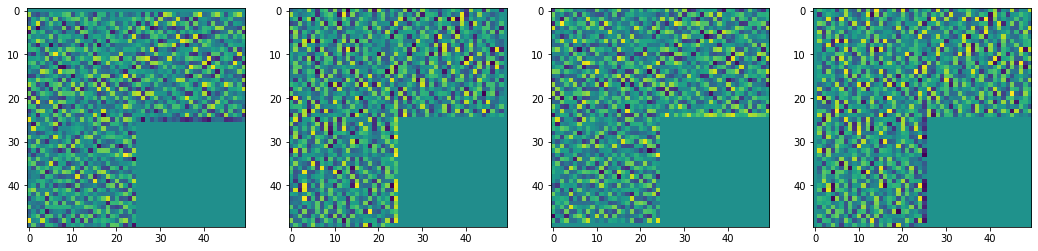

In [9]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [10]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [11]:
square, square.shape

(tensor([[[0.5294, 0.5041, 0.5006,  ..., 0.5019, 0.6156, 0.5000],
          [0.7015, 0.5336, 0.5781,  ..., 0.5615, 0.6176, 0.5005],
          [0.5694, 0.5305, 0.6532,  ..., 0.5230, 0.5166, 0.5202],
          ...,
          [0.5587, 0.5162, 0.6059,  ..., 0.5000, 0.5000, 0.5000],
          [0.7564, 0.5205, 0.5168,  ..., 0.5000, 0.5000, 0.5000],
          [0.5350, 0.5918, 0.5158,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.6303, 0.5373, 0.5662,  ..., 0.5584, 0.7140, 0.5005],
          [0.6703, 0.5076, 0.5170,  ..., 0.5217, 0.5149, 0.5202],
          [0.5333, 0.5283, 0.7769,  ..., 0.5112, 0.5033, 0.5142],
          ...,
          [0.7241, 0.5075, 0.5590,  ..., 0.5000, 0.5000, 0.5000],
          [0.6079, 0.5695, 0.5298,  ..., 0.5000, 0.5000, 0.5000],
          [0.5089, 0.5436, 0.5018,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.6058, 0.5611, 0.5693,  ..., 0.5570, 0.6186, 0.6161],
          [0.5694, 0.6185, 0.5031,  ..., 0.5463, 0.5195, 0.5208],
          [0.5333, 0.5051, 0.6735,  ...,

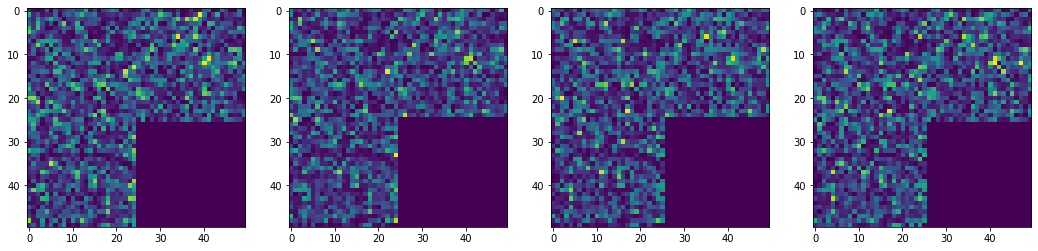

In [12]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [13]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [14]:
vertex_area = square.sum(axis=0)

In [15]:
vertex_area, vertex_area.shape

(tensor([[1.2361, 1.6278, 1.6396,  ..., 1.6157, 1.8345, 1.2317],
         [1.9411, 2.2997, 2.1640,  ..., 2.2140, 2.2733, 1.5225],
         [1.6359, 2.0713, 2.6298,  ..., 2.0795, 2.0485, 1.5592],
         ...,
         [1.9755, 2.1197, 2.2299,  ..., 2.0000, 2.0000, 1.5000],
         [1.8908, 2.3063, 2.0992,  ..., 2.0000, 2.0000, 1.5000],
         [1.0439, 1.6954, 1.5741,  ..., 1.5000, 1.5000, 1.0000]],
        device='cuda:0'),
 torch.Size([50, 50]))

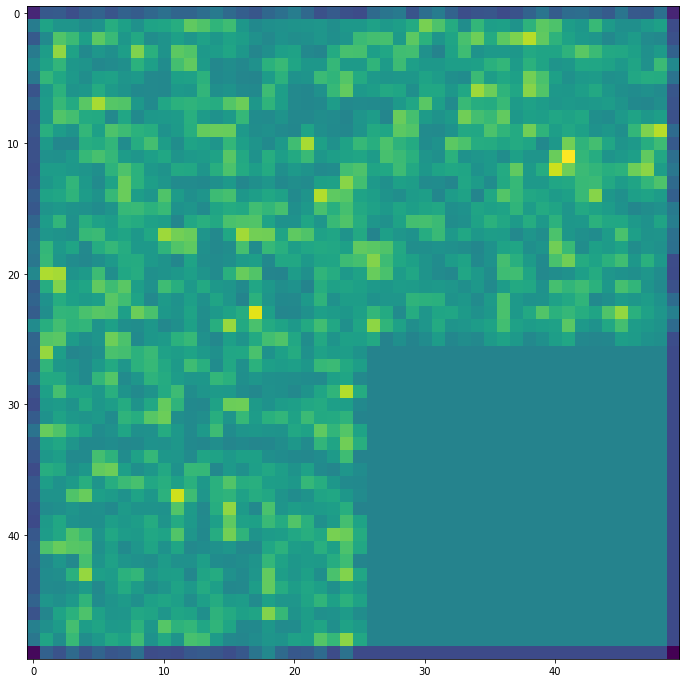

In [16]:
plt.imshow(vertex_area.cpu().numpy())

In [17]:
del square, arr
torch.cuda.empty_cache()

In [18]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[0, 0, :] = 0
cotangens[1, :, -1] = 0
cotangens[2, -1, :] = 0
cotangens[3, :, 0] = 0

In [19]:
main_i = torch.arange(end=N, device=device)
upper_edge_i = torch.arange(start=W, end=N, device=device)
right_edge_i = main_i[cotangens[1].view(-1) != 0]
left_edge_i = main_i[cotangens[3].view(-1) != 0]
down_edge_i = torch.arange(start=0, end=N-W, device=device)

In [20]:
main_v = cotangens.sum(axis=0).view(-1)
upper_edge_v = cotangens[0].view(-1)[upper_edge_i]
right_edge_v = cotangens[1].view(-1)[right_edge_i]
down_edge_v = cotangens[2].view(-1)[down_edge_i]
left_edge_v = cotangens[3].view(-1)[left_edge_i]

In [21]:
# cu.cuda.Device(0).use()

main_v = cu.fromDlpack(to_dlpack(main_v))
main_i = cu.fromDlpack(to_dlpack(main_i))

upper_edge_v = cu.fromDlpack(to_dlpack(upper_edge_v))
upper_edge_i = cu.fromDlpack(to_dlpack(upper_edge_i))

right_edge_v = cu.fromDlpack(to_dlpack(right_edge_v))
right_edge_i = cu.fromDlpack(to_dlpack(right_edge_i))

down_edge_v = cu.fromDlpack(to_dlpack(down_edge_v))
down_edge_i = cu.fromDlpack(to_dlpack(down_edge_i))


left_edge_v = cu.fromDlpack(to_dlpack(left_edge_v))
left_edge_i = cu.fromDlpack(to_dlpack(left_edge_i))

In [22]:
upper_m = scipy.sparse.coo_matrix((upper_edge_v / 2, (upper_edge_i, main_i[:-W])), shape=(N, N))
right_m = scipy.sparse.coo_matrix((right_edge_v / 2, (right_edge_i, right_edge_i + 1)), shape=(N, N))
down_m = scipy.sparse.coo_matrix((down_edge_v / 2, (down_edge_i, main_i[W:])), shape=(N, N))
left_m = scipy.sparse.coo_matrix((left_edge_v / 2, (left_edge_i, left_edge_i - 1)), shape=(N, N))
main_m = scipy.sparse.diags(-main_v / 2)

In [23]:
L = main_m + upper_m + right_m + down_m + left_m

In [24]:
M = scipy.sparse.diags(cu.fromDlpack(to_dlpack(vertex_area.view(-1) / 3)))

In [25]:
M.dtype, L.dtype

(dtype('float32'), dtype('float32'))

In [26]:
b = cu.zeros(N, dtype=cu.float32)
b[W+10] = 1
b[3*W+20] = 1
b.dtype

dtype('float32')

In [27]:
del main_m, upper_m, right_m, down_m, left_m
del vertex_area
del main_v, main_i, upper_edge_v, upper_edge_i, right_edge_v, right_edge_i, down_edge_v, down_edge_i, left_edge_v, left_edge_i
torch.cuda.empty_cache()

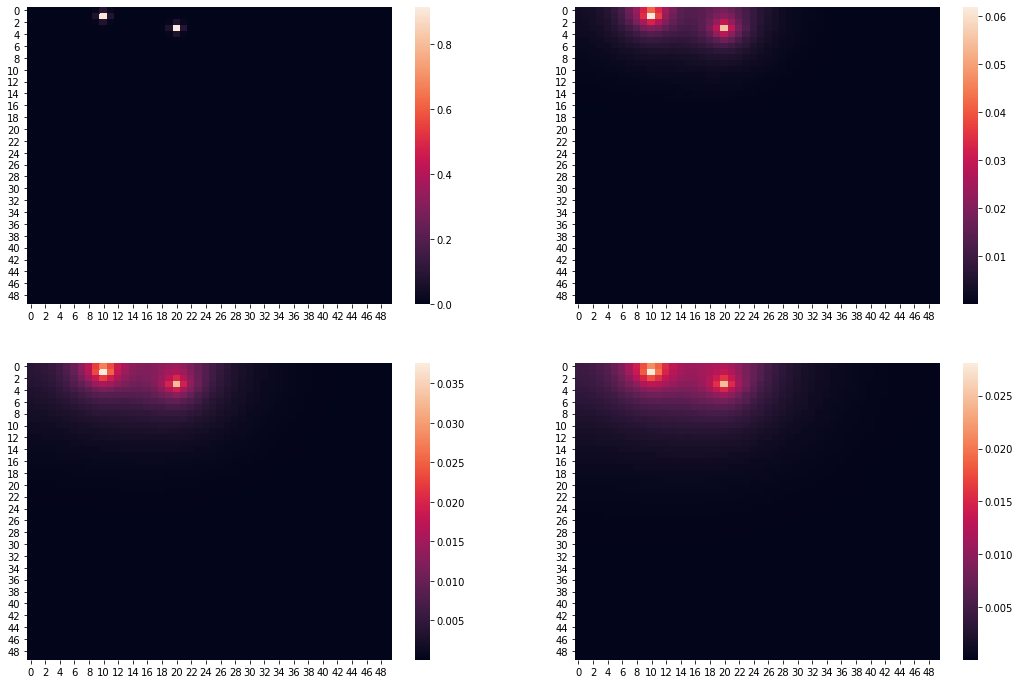

In [28]:
# u = scipy.sparse.linalg.lsqr(M - L, b)
# u = u[0]
for i in range(4):
    u = scipy.sparse.linalg.lsqr(M - (0.1 +  10 * i) * L, b)
    u = u[0]
    plt.subplot(2, 2, 1 + i)
    sns.heatmap(cu.asnumpy(u.reshape(H, W)))
#     del u
#     torch.cuda.empty_cache()

In [29]:
(u == 0).sum(), u.shape[0]

(array(0), 2500)

In [ ]:
_ = plt.hist(cu.asnumpy(u.reshape(H, W).clip(0, 0.1)))